Visualization of Kaggle Data

In [1]:
from src.data.data_loader import load_data
from src.data.data_cleaner import clean_data

data = clean_data(data=load_data(), data_source_name="kaggle_brisT1D")

In [2]:
print(data["p_num"].unique())

['p01' 'p02' 'p03' 'p04' 'p05' 'p06' 'p10' 'p11' 'p12']


/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_45729/467858502.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  patient_data['hour'] = pd.to_datetime(patient_data['time'].astype(str)).dt.hour
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_45729/467858502.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  patient_data['hour'] = pd.to_datetime(patient_data['time'].astype(str)).dt.hour
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_45729/467858502.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  patient_data['hour'] = pd.to_datetim

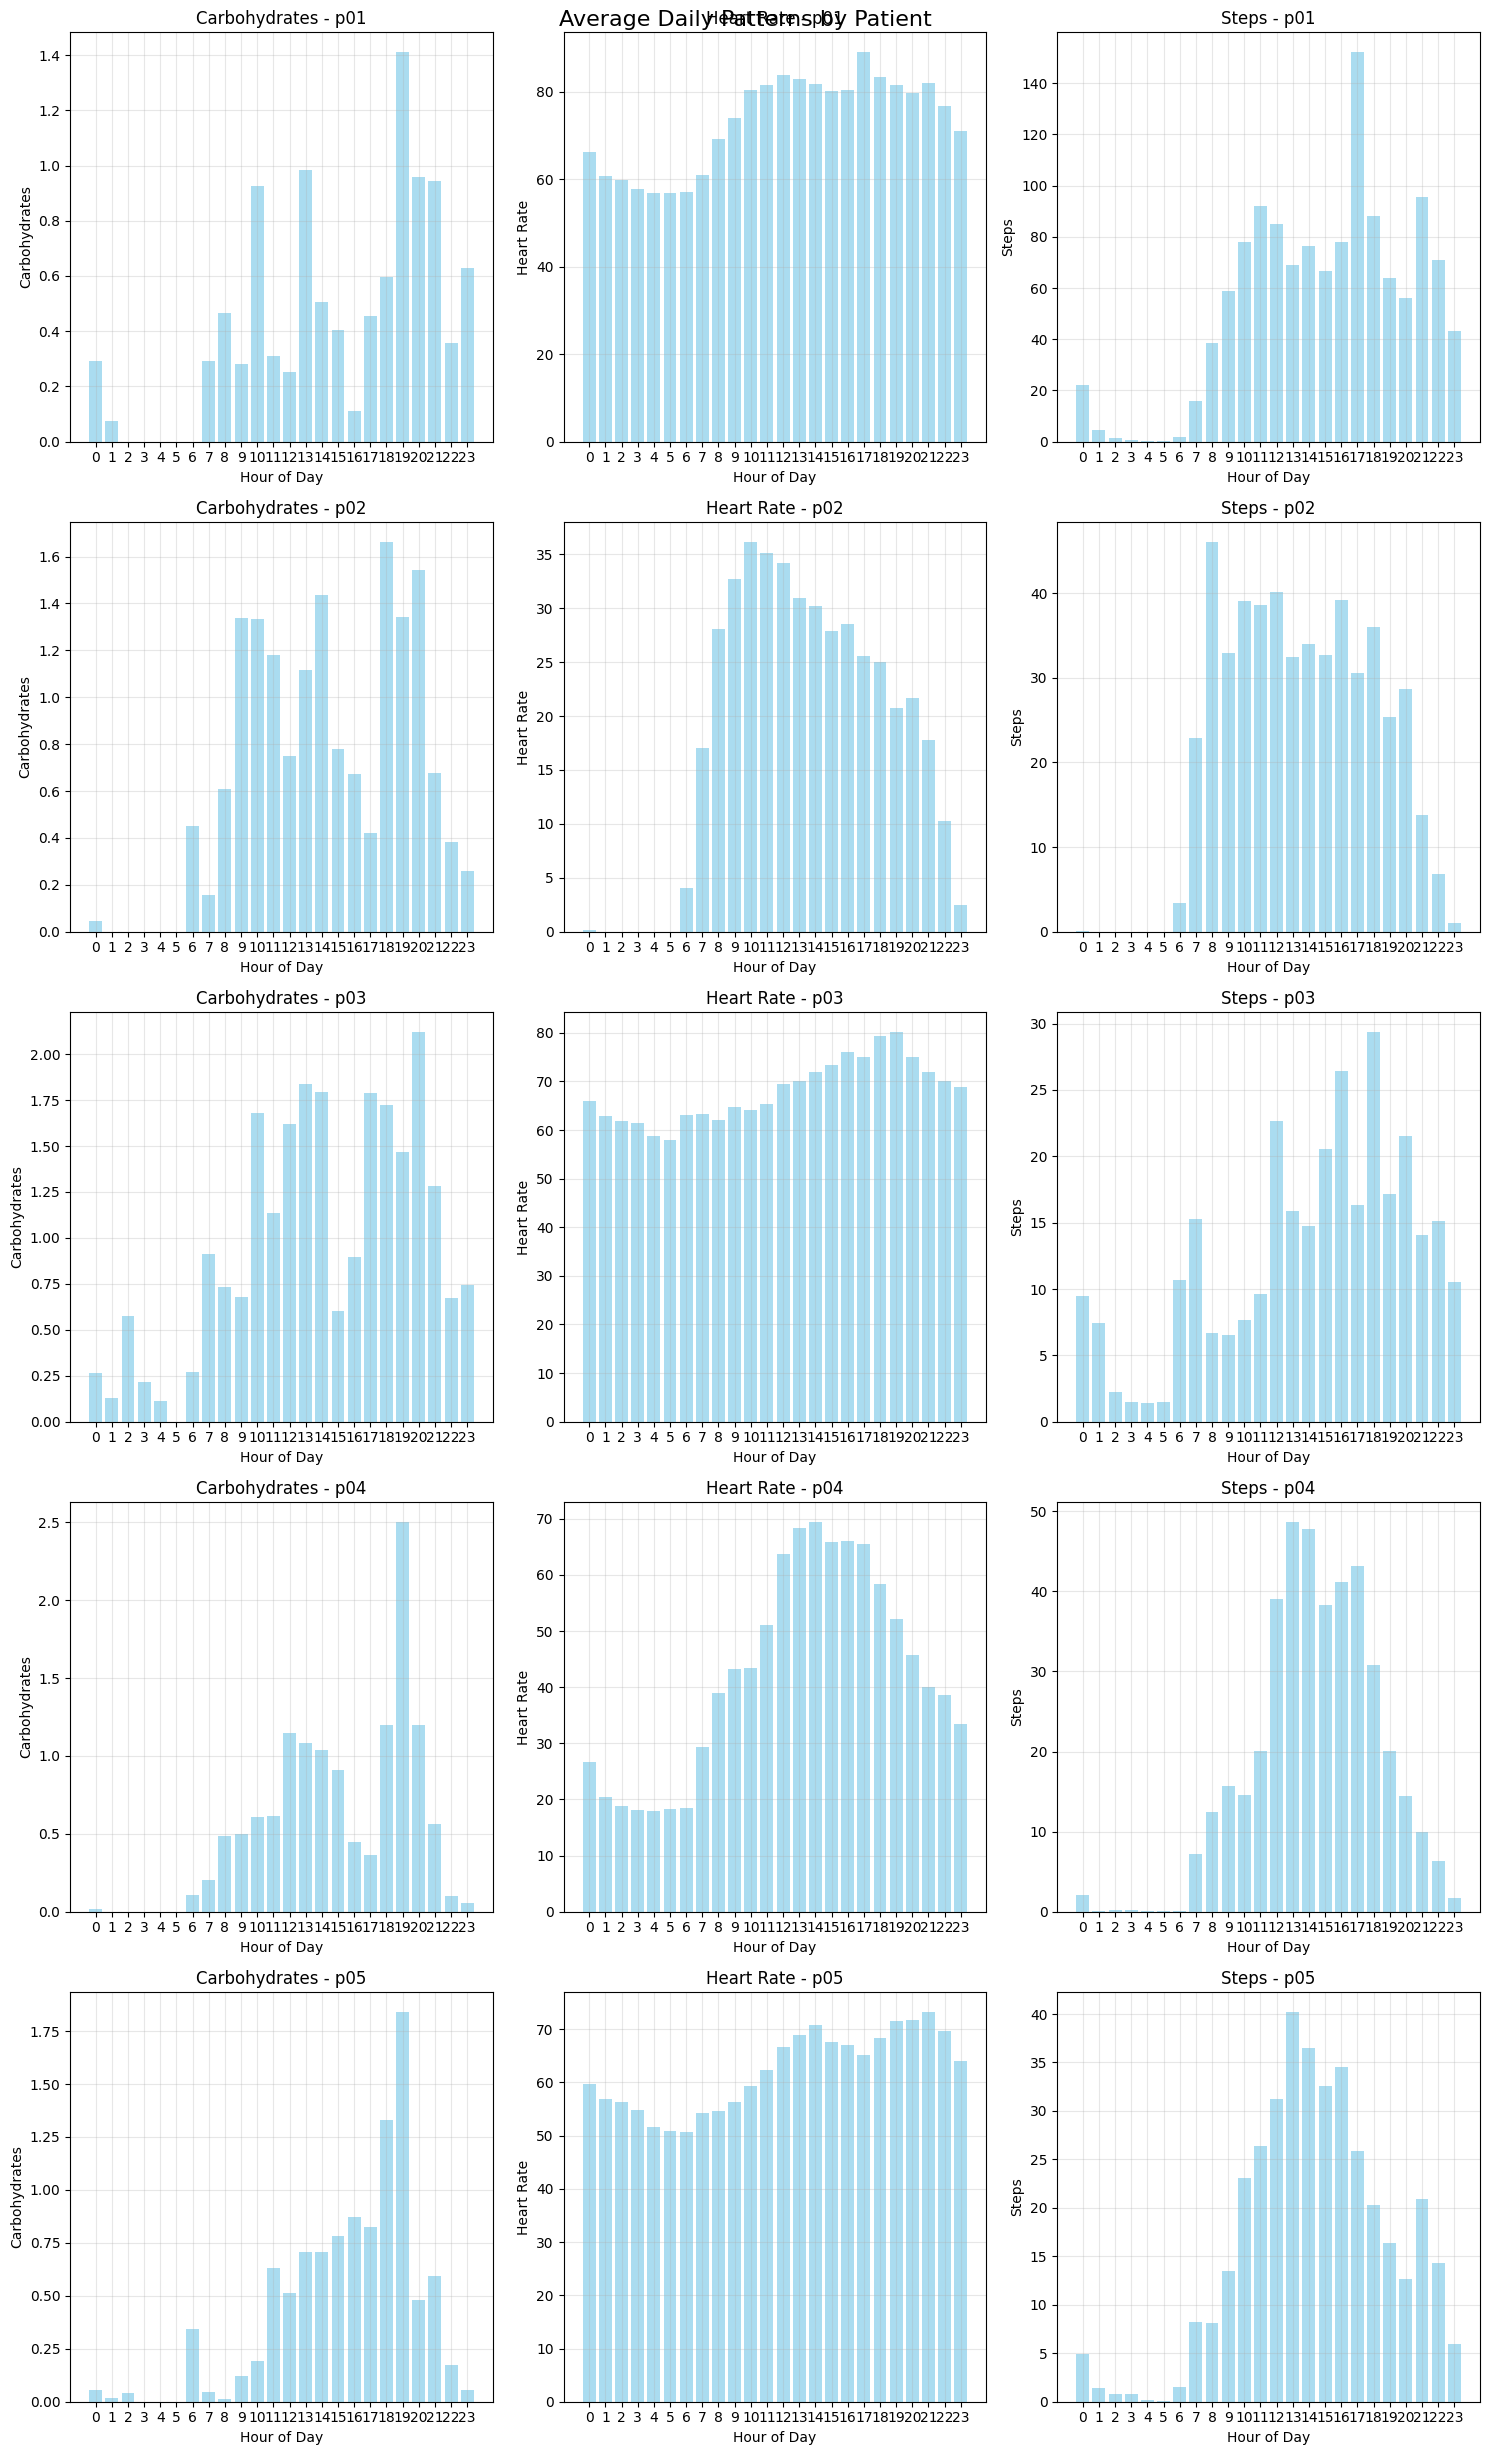

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Get first 5 patients
patients = data["p_num"].unique()[:5]

# Create figure with 5x3 subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle("Average Daily Patterns by Patient", fontsize=16)

metrics = ["Carbohydrates", "Heart Rate", "Steps"]
columns = ["carbs-0:00", "hr-0:00", "steps-0:00"]

for p_idx, patient in enumerate(patients):
    # Get data for current patient
    patient_data = data[data["p_num"] == patient].copy()

    # Convert time strings to datetime.time objects
    patient_data["time"] = pd.to_datetime(
        patient_data["time"], format="%H:%M:%S"
    ).dt.time

    # Extract hour from time
    patient_data["hour"] = pd.to_datetime(patient_data["time"].astype(str)).dt.hour

    # Fill NaN values with 0
    for col in columns:
        patient_data[col] = patient_data[col].fillna(0)

    # Plot each metric for current patient
    for m_idx, (metric, column) in enumerate(zip(metrics, columns)):
        hourly_mean = patient_data.groupby("hour")[column].mean()

        axes[p_idx, m_idx].bar(range(24), hourly_mean, color="skyblue", alpha=0.7)
        axes[p_idx, m_idx].set_title(f"{metric} - {patient}")
        axes[p_idx, m_idx].set_xlabel("Hour of Day")
        axes[p_idx, m_idx].set_ylabel(metric)
        axes[p_idx, m_idx].grid(True, alpha=0.3)
        axes[p_idx, m_idx].set_xticks(range(24))

plt.tight_layout()
plt.show()

In [4]:
patient_data = data[data["p_num"] == "p01"]
patient_data.head(1000)

,id,p_num,time,bg-0:00,insulin-0:00,carbs-0:00,hr-0:00,steps-0:00,cals-0:00,activity-0:00
0,p01_0,p01,06:10:00,15.1,0.0417,NaN,NaN,NaN,NaN,NaN
1,p01_1,p01,06:25:00,14.4,0.0417,NaN,NaN,NaN,NaN,NaN
2,p01_2,p01,06:40:00,13.9,0.0417,NaN,NaN,NaN,NaN,NaN
3,p01_3,p01,06:55:00,13.8,0.0417,NaN,NaN,NaN,NaN,NaN
4,p01_4,p01,07:10:00,13.4,0.0417,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
995,p01_995,p01,00:15:00,7.2,0.0083,NaN,71.7,6.0,9.63,NaN
996,p01_996,p01,00:30:00,6.7,0.0083,NaN,76.1,62.0,5.00,NaN
997,p01_997,p01,00:45:00,6.2,0.0083,NaN,54.9,0.0,5.30,NaN
998,p01_998,p01,01:00:00,5.1,0.0083,NaN,53.6,NaN,8.66,NaN


In [52]:
# Convert time strings to datetime.time objects to extract hours
patient_data["time"] = pd.to_datetime(patient_data["time"], format="%H:%M:%S").dt.time

# Initialize variables
day_start_rows = []
prev_hour = None

# Traverse rows one by one
for idx, row in patient_data.iterrows():
    curr_hour = row["time"].hour

    # Check if we transitioned from 23:xx to 00:xx
    if prev_hour == 23 and curr_hour == 0:
        day_start_rows.append(idx)

    prev_hour = curr_hour

# Get the dataframe rows for day starts
day_start_rows = patient_data.loc[day_start_rows]

# Display first 100 rows to verify
day_start_rows.iloc[280:300]

/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_39671/3306070878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['time'] = pd.to_datetime(patient_data['time'], format='%H:%M:%S').dt.time


,id,p_num,time,bg-0:00,insulin-0:00,carbs-0:00,hr-0:00,steps-0:00,cals-0:00,activity-0:00


In [35]:
def find_sleep_window(data):
    """
    Find optimal sleep window by analyzing activity around midnight
    Returns start and end hour of sleep window
    """
    patient_data = data.copy()

    # Find rows closest to midnight (00:00)
    midnight_rows = patient_data[pd.to_datetime(patient_data["time"]).dt.hour == 0]
    # Create a copy of the dataframe to avoid modifying the original

    if midnight_rows.empty:
        return None, None

    min_avg_metrics = float("inf")
    optimal_window = (22, 2)  # Default window 10pm-2am

    # For each midnight row, check ±2 hour windows
    for idx in midnight_rows.index:
        # Get data 2 hours before and after midnight
        window_data = patient_data[
            (patient_data["hour"] >= 22) | (patient_data["hour"] <= 2)
        ]

        # Calculate average metrics for this window
        avg_metrics = (
            window_data["steps-0:00"].mean()
            + window_data["carbs-0:00"].mean()
            + window_data["hr-0:00"].mean()
        )

        if avg_metrics < min_avg_metrics:
            min_avg_metrics = avg_metrics
            optimal_window = (22, 2)  # 10pm to 2am window

    return optimal_window


find_sleep_window(patient_data)

/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_39671/289557349.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  midnight_rows = patient_data[pd.to_datetime(patient_data['time']).dt.hour == 0]


KeyError: 'hour'